# Degree Correlation of the Time-Averaged Networks
Take the afternoon-network as example.

## The Time-Averaged Networks Data

In [1]:
# Use NCF conda environment
import pandas as pd
import numpy as np

network_period = "Night.csv"
df_od_afternoon = pd.read_csv("/root/DataPrac/proj/zc_work/data/timeperiod/NYCTAXI_OD_" + network_period, index_col=0)
df_od_afternoon

,origin_id,destination_id,flow
0,0,208,0.002747
1,1,200,0.002747
2,2,87,0.005495
3,2,167,0.002747
4,2,219,0.002747
...,...,...,...
11219,262,257,0.002747
11220,262,258,0.002747
11221,262,259,0.030220
11222,262,260,0.016484


## Those not recorded OD pairs have flow 0

In [2]:
263*263

69169

## In-degree and Out-degree Correlation
Is a node is balanced in terms of in-degree and out-degree? If is, treat the network as undirected when analyzing the degree correlation.

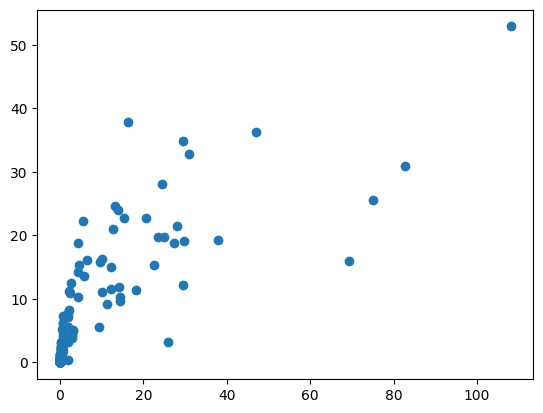

In [3]:
in_degrees = df_od_afternoon.groupby("origin_id")["flow"].sum()
out_degrees = df_od_afternoon.groupby("destination_id")["flow"].sum()

# Complete the series with omitted 0s
in_degrees = in_degrees.reindex(range(263), fill_value=0)
out_degrees = out_degrees.reindex(range(263), fill_value=0)
import matplotlib.pyplot as plt
plt.scatter(in_degrees, out_degrees)

Hence replace the original links with the undirected links, weighted by the sum of the two directions.

In [4]:
df_unweighted_od_afternoon = df_od_afternoon[["origin_id", "destination_id", "flow"]].copy()
df_unweighted_od_afternoon[["origin_id", "destination_id"]] = \
    np.sort(df_unweighted_od_afternoon[["origin_id", "destination_id"]].values, axis=1)
df_unweighted_od_afternoon = df_unweighted_od_afternoon.\
    groupby(["origin_id", "destination_id"], as_index=False)["flow"].sum()
df_unweighted_od_afternoon

,origin_id,destination_id,flow
0,0,6,0.002747
1,0,12,0.010989
2,0,13,0.002747
3,0,23,0.005495
4,0,36,0.002747
...,...,...,...
8196,259,261,0.008242
8197,259,262,0.032967
8198,260,261,0.030220
8199,260,262,0.063187


## The Degree Correlation Matrix
The degree correlation matrix for a undirected, unweighted network is defined as the matrix $(e_{ij})$, where $e_{ij}$ is the probability that a random chosen link connects a node of degree $i$ to a node of degree $j$. 

In an weighted network, the degree correlation matrix (or the degree correlation diagram) is defined as the matrix $(w_{ij})$, where $w_{ij}$ is the average weight of the links connecting a node of degree $i$ to a node of degree $j$. Here $i$ and $j$ are computed by the sum of weights of linked edges, which can be non-integer.

In [5]:
degs = in_degrees + out_degrees
degs

origin_id
0       1.052198
1       0.005495
2       0.074176
3      23.714286
4       0.005495
         ...    
258     0.140110
259     1.898352
260    10.359890
261    15.046703
262    38.052198
Name: flow, Length: 263, dtype: float64

In [6]:
deg_corr_matrix = pd.DataFrame({"deg_small_id": [], "deg_big_id": [], "flow": []})

for index, row in df_unweighted_od_afternoon.iterrows():
    deg_small_id = degs[row['origin_id']]
    deg_big_id = degs[row['destination_id']]
    new_row = pd.DataFrame({"deg_small_id": [deg_small_id], "deg_big_id": [deg_big_id], "flow": [row['flow']]})
    deg_corr_matrix = pd.concat([deg_corr_matrix, new_row], ignore_index=True)
    
deg_corr_matrix

,deg_small_id,deg_big_id,flow
0,1.052198,7.054945,0.002747
1,1.052198,8.107143,0.010989
2,1.052198,0.956044,0.002747
3,1.052198,4.741758,0.005495
4,1.052198,3.420330,0.002747
...,...,...,...
8196,1.898352,15.046703,0.008242
8197,1.898352,38.052198,0.032967
8198,10.359890,15.046703,0.030220
8199,10.359890,38.052198,0.063187


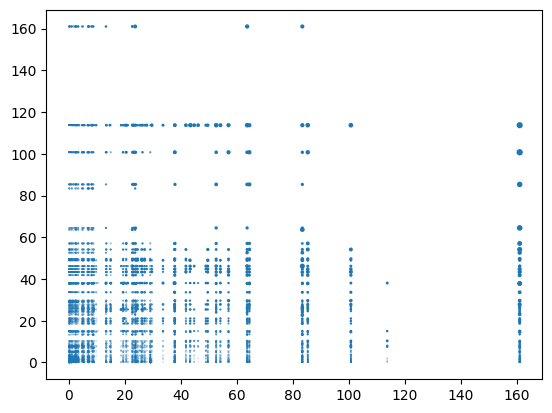

In [7]:
plt.scatter(deg_corr_matrix["deg_small_id"], deg_corr_matrix["deg_big_id"], s=deg_corr_matrix["flow"])

The dots on the diagonal appears much larger, showing an assortative structure.
Here comes a regular plot of the degree correlation matrix, obtained by discretizing the degree values or taking bins.

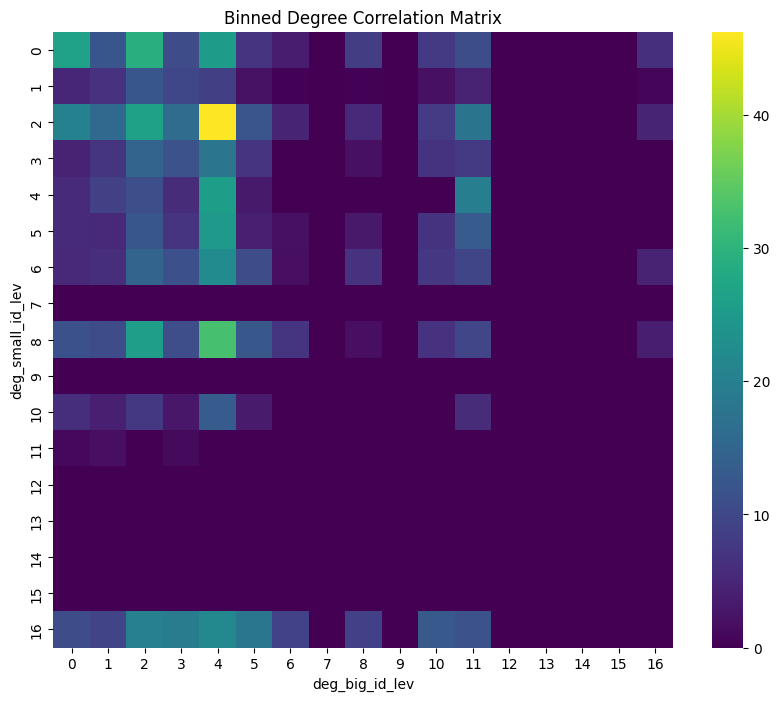

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 10
deg_corr_matrix_binned = deg_corr_matrix.copy(deep=True)
deg_corr_matrix_binned["deg_small_id_lev"] = deg_corr_matrix_binned["deg_small_id"] // bin_width
deg_corr_matrix_binned["deg_big_id_lev"] = deg_corr_matrix_binned["deg_big_id"] // bin_width
deg_corr_matrix_binned = deg_corr_matrix_binned.groupby \
    (["deg_small_id_lev", "deg_big_id_lev"], as_index=False)["flow"].sum()

# 创建一个包含所有需要的索引的列表
index_range = np.arange(0, 17)

# 使用 reindex 方法添加缺失的行和列
deg_corr_matrix_binned = deg_corr_matrix_binned.pivot(index='deg_small_id_lev', columns='deg_big_id_lev', values='flow')
deg_corr_matrix_binned = deg_corr_matrix_binned.reindex(index_range, axis=0).reindex(index_range, axis=1)

# 使用 fillna 方法填充 NaN 值
deg_corr_matrix_binned = deg_corr_matrix_binned.fillna(0)  

plt.figure(figsize=(10, 8))
sns.heatmap(deg_corr_matrix_binned, cmap='viridis')
plt.title('Binned Degree Correlation Matrix')
plt.show()

Due to the large value of (46,46) grid, the assortative structure is not so clear. Remove the last row and column, to distinguish the colors.

## Average Nearest Neighbor Degree (ANND) $k_{nn}$

In [9]:
df_unweighted_od_afternoon_nd = df_unweighted_od_afternoon.copy(deep=True)

bin_width = 1
df_unweighted_od_afternoon_nd["k_lev"] = \
    df_unweighted_od_afternoon_nd["origin_id"].apply(lambda x: degs[x] // bin_width)
df_unweighted_od_afternoon_nd["deg_destination_lev"] = \
    df_unweighted_od_afternoon_nd["destination_id"].apply(lambda x: degs[x] // bin_width)

In [10]:
df_unweighted_od_afternoon_nd

,origin_id,destination_id,flow,k_lev,deg_destination_lev
0,0,6,0.002747,1.0,7.0
1,0,12,0.010989,1.0,8.0
2,0,13,0.002747,1.0,0.0
3,0,23,0.005495,1.0,4.0
4,0,36,0.002747,1.0,3.0
...,...,...,...,...,...
8196,259,261,0.008242,1.0,15.0
8197,259,262,0.032967,1.0,38.0
8198,260,261,0.030220,10.0,15.0
8199,260,262,0.063187,10.0,38.0


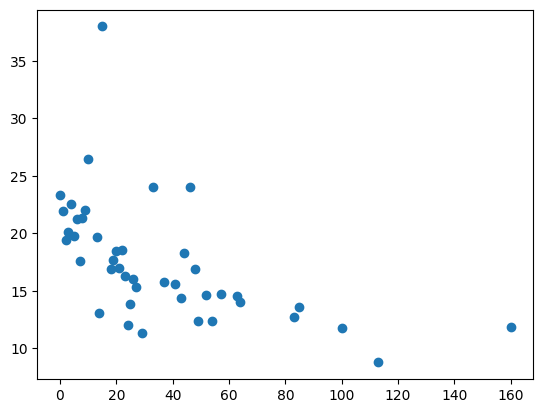

In [11]:
knn_k = df_unweighted_od_afternoon_nd.groupby("k_lev")["deg_destination_lev"].mean()

plt.scatter(knn_k.index, knn_k)

/root/miniconda3/envs/NCF/lib/python3.9/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


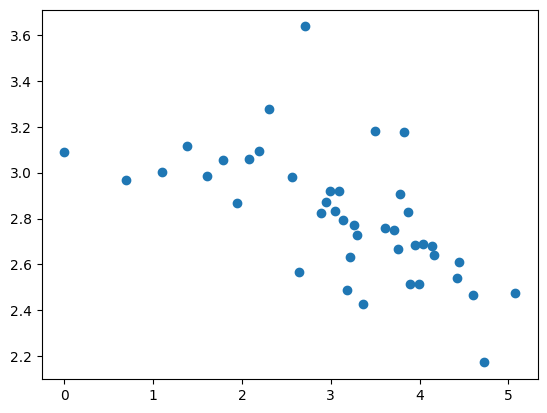

In [12]:
plt.scatter(np.log(knn_k.index), np.log(knn_k.values))

## Null Model (weight-preserving randomization)

In [13]:
import networkx as nx

G = nx.Graph()
for index, row in df_unweighted_od_afternoon.iterrows():
    G.add_edge(row['origin_id'], row['destination_id'], weight=row['flow'])

In [14]:
degree_corr = nx.degree_assortativity_coefficient(G, weight='weight')
degree_corr

-0.11043002402111977

+ Time, undirected, heat_map, knn, deg_corr
+ Afternoon: yes, assortative, neutral, neutral
+ Early Morning: no, assortative, disassortative, disassortative
+ Evening Rush: no, neutral, neutral, neutral
+ Morning Rush: no, assortative, neutral, neutral
+ Morning to Noon: yes, assortative, neutral, neutral
+ Night: no, assortative, neutral, neutral

# Comparison Study

In [15]:
periods = ["Afternoon", 
           "Early Morning", 
           "Evening Rush",
           "Morning Rush",
           "Morning to Noon",
           "Night"]

## Store the Data from Different Time Periods

In [16]:
ODs = {}

for period in periods: 
    # Load the OD data
    ODs[period] = {}
    ODs[period]["df_od"] = pd.read_csv("/root/DataPrac/proj/zc_work/data/timeperiod/NYCTAXI_OD_"
                                 + period + ".csv", index_col=0)
    
    # Calculate in and out degrees. "plt.scatter(in_degrees, out_degrees)" to plot the in-out correlation.
    in_degrees = ODs[period]["df_od"].groupby("origin_id")["flow"].sum()
    out_degrees = ODs[period]["df_od"].groupby("destination_id")["flow"].sum()
    ODs[period]["in_degrees"] = in_degrees.reindex(range(263), fill_value=0)
    ODs[period]["out_degrees"] = out_degrees.reindex(range(263), fill_value=0)
    
    # Obtain the unweighted OD matrix
    df_unweighted_od = (ODs[period]["df_od"]) [["origin_id", "destination_id", "flow"]].copy()
    df_unweighted_od[["origin_id", "destination_id"]] = \
        np.sort(df_unweighted_od[["origin_id", "destination_id"]].values, axis=1)
    df_unweighted_od = df_unweighted_od.\
        groupby(["origin_id", "destination_id"], as_index=False)["flow"].sum()
    ODs[period]["df_unweighted_od"] = df_unweighted_od
    
    # Degrees in the unweighted OD 
    ODs[period]["degs"] = ODs[period]["in_degrees"] + ODs[period]["out_degrees"]
    
    # Degree correlation matrix
    deg_corr_matrix = pd.DataFrame({"deg_small_id": [], "deg_big_id": [], "flow": []})
    for index, row in ODs[period]["df_unweighted_od"].iterrows():
        deg_small_id = ODs[period]["degs"][row['origin_id']]
        deg_big_id = ODs[period]["degs"][row['destination_id']]
        new_row = pd.DataFrame({"deg_small_id": [deg_small_id], "deg_big_id": [deg_big_id], "flow": [row['flow']]})
        deg_corr_matrix = pd.concat([deg_corr_matrix, new_row], ignore_index=True)
    ODs[period]["deg_corr_matrix"] = deg_corr_matrix
    
    # knn_k
    ODs[period]["df_unweighted_od_nd"] = ODs[period]["df_unweighted_od"].copy(deep=True)
    bin_width = 1
    ODs[period]["df_unweighted_od_nd"]["k_lev"] = \
        ODs[period]["df_unweighted_od_nd"]["origin_id"].apply(lambda x: ODs[period]["degs"][x] // bin_width)
    ODs[period]["df_unweighted_od_nd"]["deg_destination_lev"] = \
        ODs[period]["df_unweighted_od_nd"]["destination_id"].apply(lambda x: ODs[period]["degs"][x] // bin_width)
    knn_k = ODs[period]["df_unweighted_od_nd"].groupby("k_lev")["deg_destination_lev"].mean()
    ODs[period]["knn_k"] = knn_k
    
    # Degree correlation coefficient
    G = nx.Graph()
    for index, row in ODs[period]["df_unweighted_od"].iterrows():
        G.add_edge(row['origin_id'], row['destination_id'], weight=row['flow'])
    ODs[period]["deg_corr_coef"] = nx.degree_assortativity_coefficient(G, weight='weight')
    

In [17]:
# Obtain the binned degree correlation matrix for plotting
def getDegCorrMatrixBinned(deg_corr_matrix, bin_width=30, filter=[False, None]):
    """
    filter: [True, [L, U]] to filter out the degrees that are not in the range [L, U)
    """
    deg_corr_matrix_binned = deg_corr_matrix.copy(deep=True)
    if filter[0]:
        U = filter[1][1]
        L = filter[1][0]
        deg_corr_matrix_binned = deg_corr_matrix_binned[
            (deg_corr_matrix_binned["deg_small_id"] < U) & 
            (deg_corr_matrix_binned["deg_small_id"] >= L) &
            (deg_corr_matrix_binned["deg_big_id"] < U) &
            (deg_corr_matrix_binned["deg_big_id"] >= L)]
    
    deg_corr_matrix_binned["deg_small_id_lev"] = deg_corr_matrix_binned["deg_small_id"] // bin_width
    deg_corr_matrix_binned["deg_big_id_lev"] = deg_corr_matrix_binned["deg_big_id"] // bin_width
    deg_corr_matrix_binned = deg_corr_matrix_binned.groupby \
        (["deg_small_id_lev", "deg_big_id_lev"], as_index=False)["flow"].sum()

    max_lev = ODs[period]["degs"] // bin_width 
    index_range = np.arange(0, max_lev.max() + 1)
    deg_corr_matrix_binned = deg_corr_matrix_binned.pivot(index='deg_small_id_lev', columns='deg_big_id_lev', values='flow')
    deg_corr_matrix_binned = deg_corr_matrix_binned.reindex(index_range, axis=0).reindex(index_range, axis=1)

    deg_corr_matrix_binned = deg_corr_matrix_binned.fillna(0)
    
    return deg_corr_matrix_binned

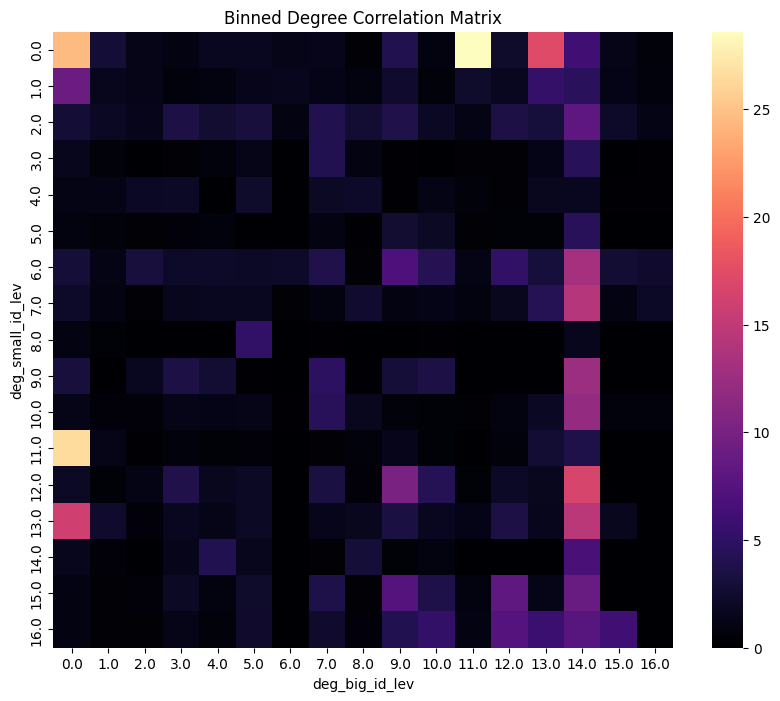

In [18]:
# An example
deg_corr_matrix_binned = getDegCorrMatrixBinned \
    (ODs["Afternoon"]["deg_corr_matrix"], bin_width=10, filter=[True, [-np.infty, 300]])

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(deg_corr_matrix_binned, cmap='magma')
plt.title('Binned Degree Correlation Matrix')
plt.show()

## In-Out Degree Correlation

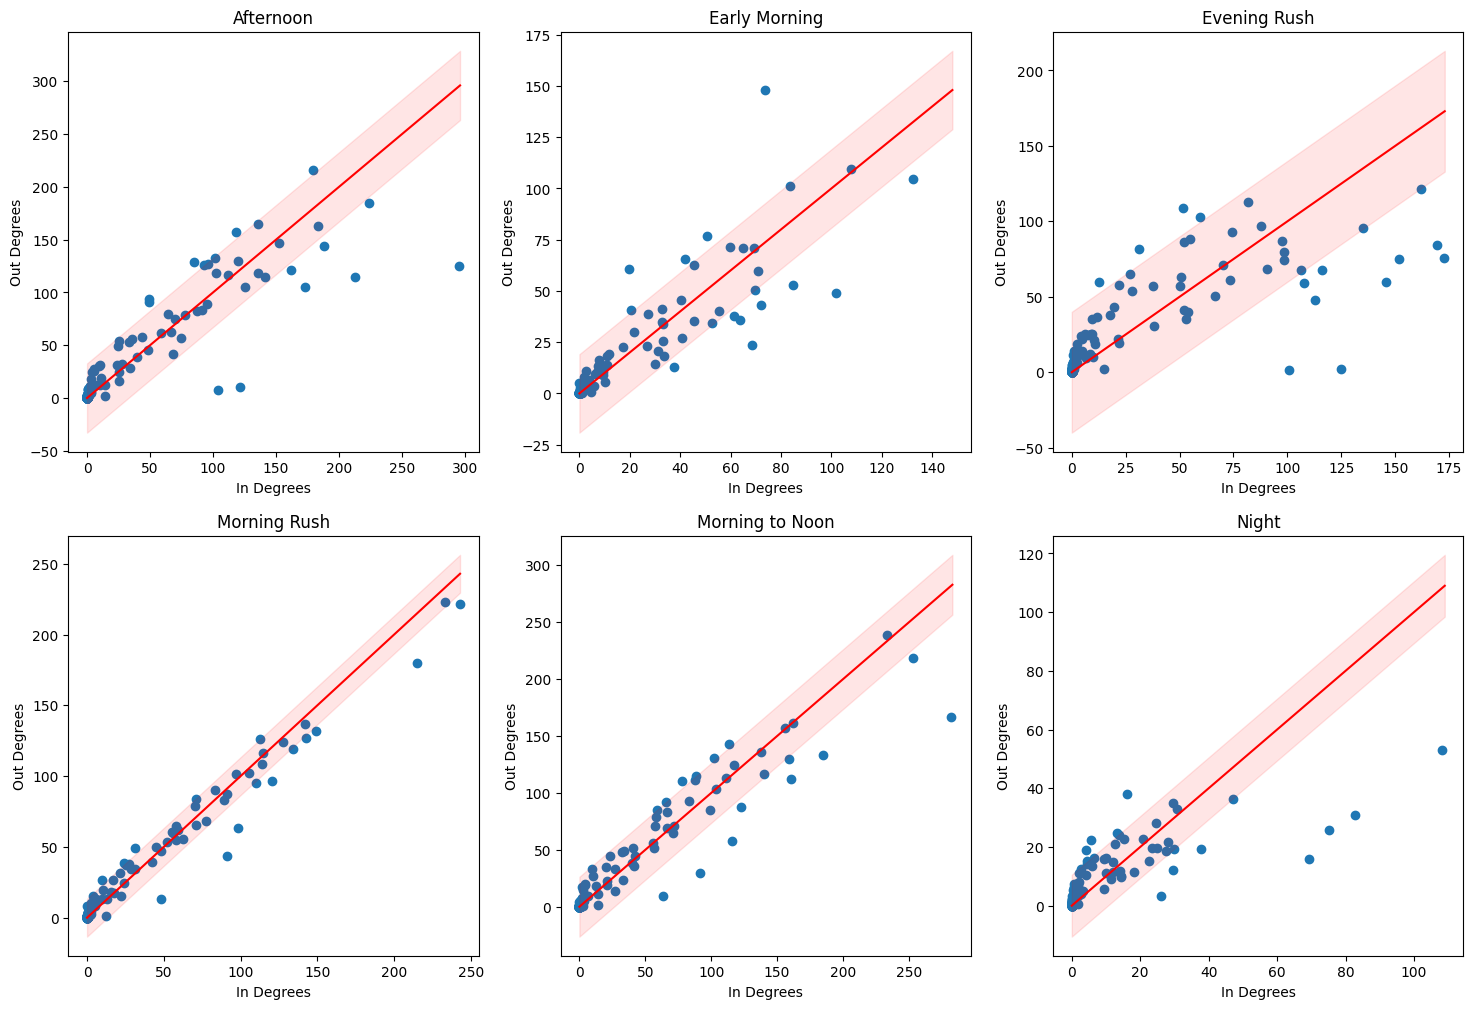

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, period in enumerate(periods):
    x = ODs[period]["in_degrees"]
    y = ODs[period]["out_degrees"]
    axs[i//3, i%3].scatter(x, y)
    
    # 获取 x 和 y 轴的最大值
    max_value = max(max(x), max(y))
    
    # 画出 y=x 的直线
    axs[i//3, i%3].plot(np.arange(max_value+1), np.arange(max_value+1), color='red')
    
    # 计算所有样本点到y=x线的距离
    distances = np.abs(x - y)
    
    # 找到使95%的样本点在y=x±a范围内的a值
    a = np.percentile(distances, 95)
    
    # 画出包含95%样本点的条带
    axs[i//3, i%3].fill_between(np.arange(max_value+1), np.arange(max_value+1)-a, np.arange(max_value+1)+a, color='red', alpha=0.1)
    
    axs[i//3, i%3].set_title(period)
    axs[i//3, i%3].set_xlabel("In Degrees")
    axs[i//3, i%3].set_ylabel("Out Degrees")

## Heat Map of Degree Correlation Matrix

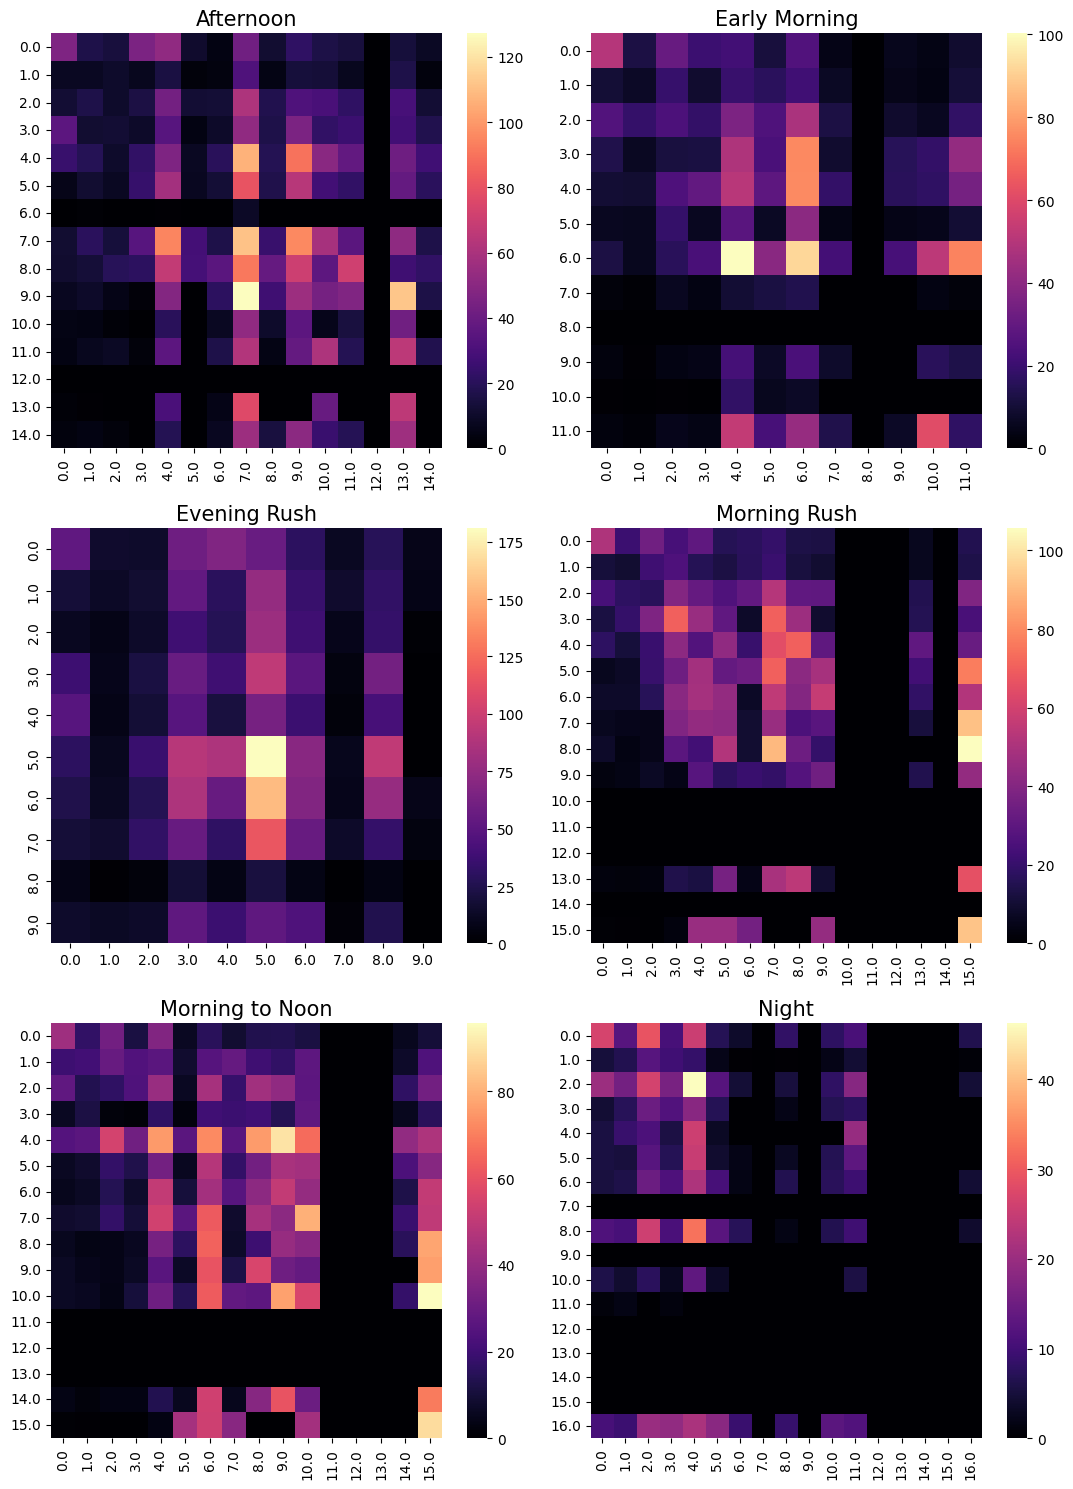

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(11, 15))

axs = axs.flatten()
bin_widths = [30, 20, 30, 30, 30, 10]
for i, period in enumerate(periods):
    deg_corr_matrix_binned = getDegCorrMatrixBinned(ODs[period]["deg_corr_matrix"], bin_width=bin_widths[i])
    sns.heatmap(deg_corr_matrix_binned, cmap='magma', ax=axs[i])
    axs[i].set_title(period, fontsize=15)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
plt.tight_layout()
plt.show()

## knn_k

In [21]:
def degree_preserving_randomization(df_unweighted_od):
    G = nx.Graph()
    for index, row in df_unweighted_od.iterrows():
        G.add_edge(row['origin_id'], row['destination_id'], weight=row['flow'])
        

    G_randm = nx.algorithms.swap.double_edge_swap(G, nswap=1000, max_tries=10000, seed=1234)

    df_unweighted_od_randm = pd.DataFrame(columns=["origin_id", "destination_id", "flow"])
    for link in G_randm.edges(data=True):
        try: 
            df_unweighted_od_randm = pd.concat([df_unweighted_od_randm, 
                                            pd.DataFrame({"origin_id": [link[0]], 
                                                          "destination_id": [link[1]], 
                                                          "flow": [link[2]["weight"]]})])
        except: df_unweighted_od_randm = pd.concat([df_unweighted_od_randm, 
                                            pd.DataFrame({"origin_id": [link[0]], 
                                                          "destination_id": [link[1]], 
                                                          "flow": 0})])
    return df_unweighted_od_randm

In [22]:
for period in periods:
    ODs[period]["df_unweighted_od_null"] = degree_preserving_randomization(ODs[period]["df_unweighted_od"])
    df_unweighted_od_null_nd = ODs[period]["df_unweighted_od_null"].copy(deep=True)
    bin_width = 1
    df_unweighted_od_null_nd["k_lev"] = \
        df_unweighted_od_null_nd["origin_id"].apply(lambda x: ODs[period]["degs"][x] // bin_width)
    df_unweighted_od_null_nd["deg_destination_lev"] = \
        df_unweighted_od_null_nd["destination_id"].apply(lambda x: ODs[period]["degs"][x] // bin_width)
    ODs[period]["df_unweighted_od_null_nd"] = df_unweighted_od_null_nd
    
    knn_k_null = ODs[period]["df_unweighted_od_null_nd"].groupby("k_lev")["deg_destination_lev"].mean()
    ODs[period]["knn_k_null"] = knn_k_null

/tmp/ipykernel_246499/3189989809.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_unweighted_od_randm = pd.concat([df_unweighted_od_randm,
/tmp/ipykernel_246499/3189989809.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_unweighted_od_randm = pd.concat([df_unweighted_od_randm,
/tmp/ipykernel_246499/3189989809.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA colu

/root/miniconda3/envs/NCF/lib/python3.9/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


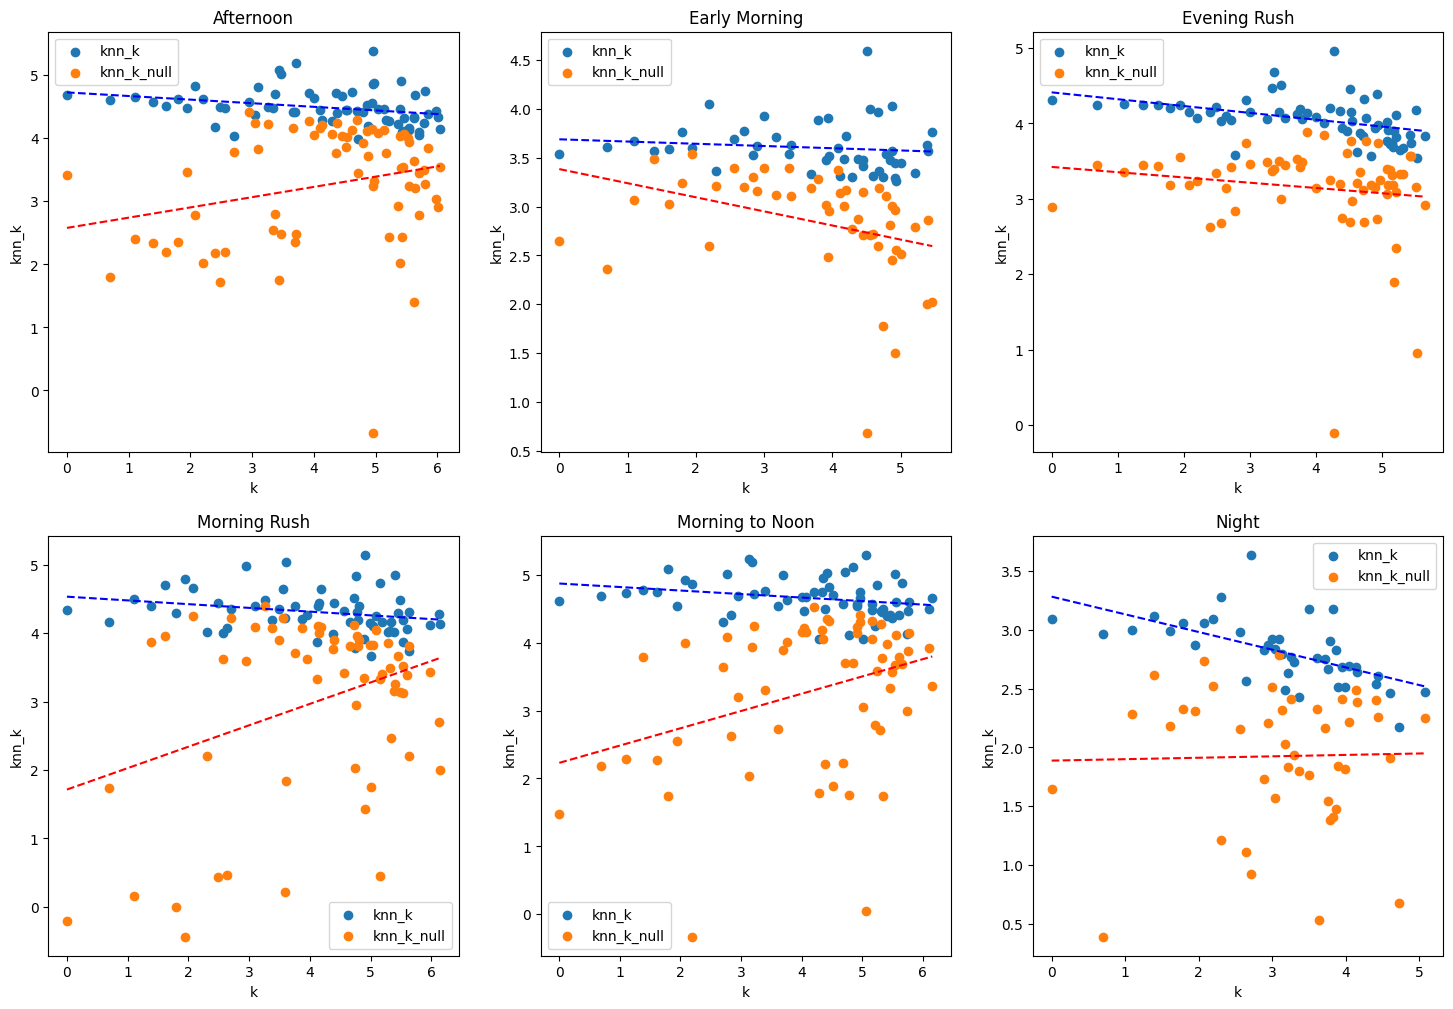

In [23]:
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, period in enumerate(periods):
    x_knn_k = np.log(ODs[period]["knn_k"].index)
    y_knn_k = np.log(ODs[period]["knn_k"])
    x_knn_k_null = np.log(ODs[period]["knn_k_null"].index)
    y_knn_k_null = np.log(ODs[period]["knn_k_null"])
    
    # 去除无穷大或 NaN 值
    mask_knn_k = ~np.isinf(x_knn_k) & ~np.isnan(x_knn_k) & ~np.isinf(y_knn_k) & ~np.isnan(y_knn_k)
    x_knn_k = x_knn_k[mask_knn_k]
    y_knn_k = y_knn_k[mask_knn_k]
    
    mask_knn_k_null = ~np.isinf(x_knn_k_null) & ~np.isnan(x_knn_k_null) & ~np.isinf(y_knn_k_null) & ~np.isnan(y_knn_k_null)
    x_knn_k_null = x_knn_k_null[mask_knn_k_null]
    y_knn_k_null = y_knn_k_null[mask_knn_k_null]
    
    axs[i//3, i%3].scatter(x_knn_k, y_knn_k, label='knn_k')
    axs[i//3, i%3].scatter(x_knn_k_null, y_knn_k_null, label='knn_k_null')
    
    # 拟合直线
    z_knn_k = np.polyfit(x_knn_k, y_knn_k, 1)
    p_knn_k = np.poly1d(z_knn_k)
    axs[i//3, i%3].plot(x_knn_k, p_knn_k(x_knn_k), "b--")
    
    z_knn_k_null = np.polyfit(x_knn_k_null, y_knn_k_null, 1)
    p_knn_k_null = np.poly1d(z_knn_k_null)
    axs[i//3, i%3].plot(x_knn_k_null, p_knn_k_null(x_knn_k_null), "r--")
    
    axs[i//3, i%3].set_title(period)
    axs[i//3, i%3].set_xlabel("k")
    axs[i//3, i%3].set_ylabel("knn_k")
    axs[i//3, i%3].legend()

/tmp/ipykernel_246499/2685999287.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i//3, i%3].legend()


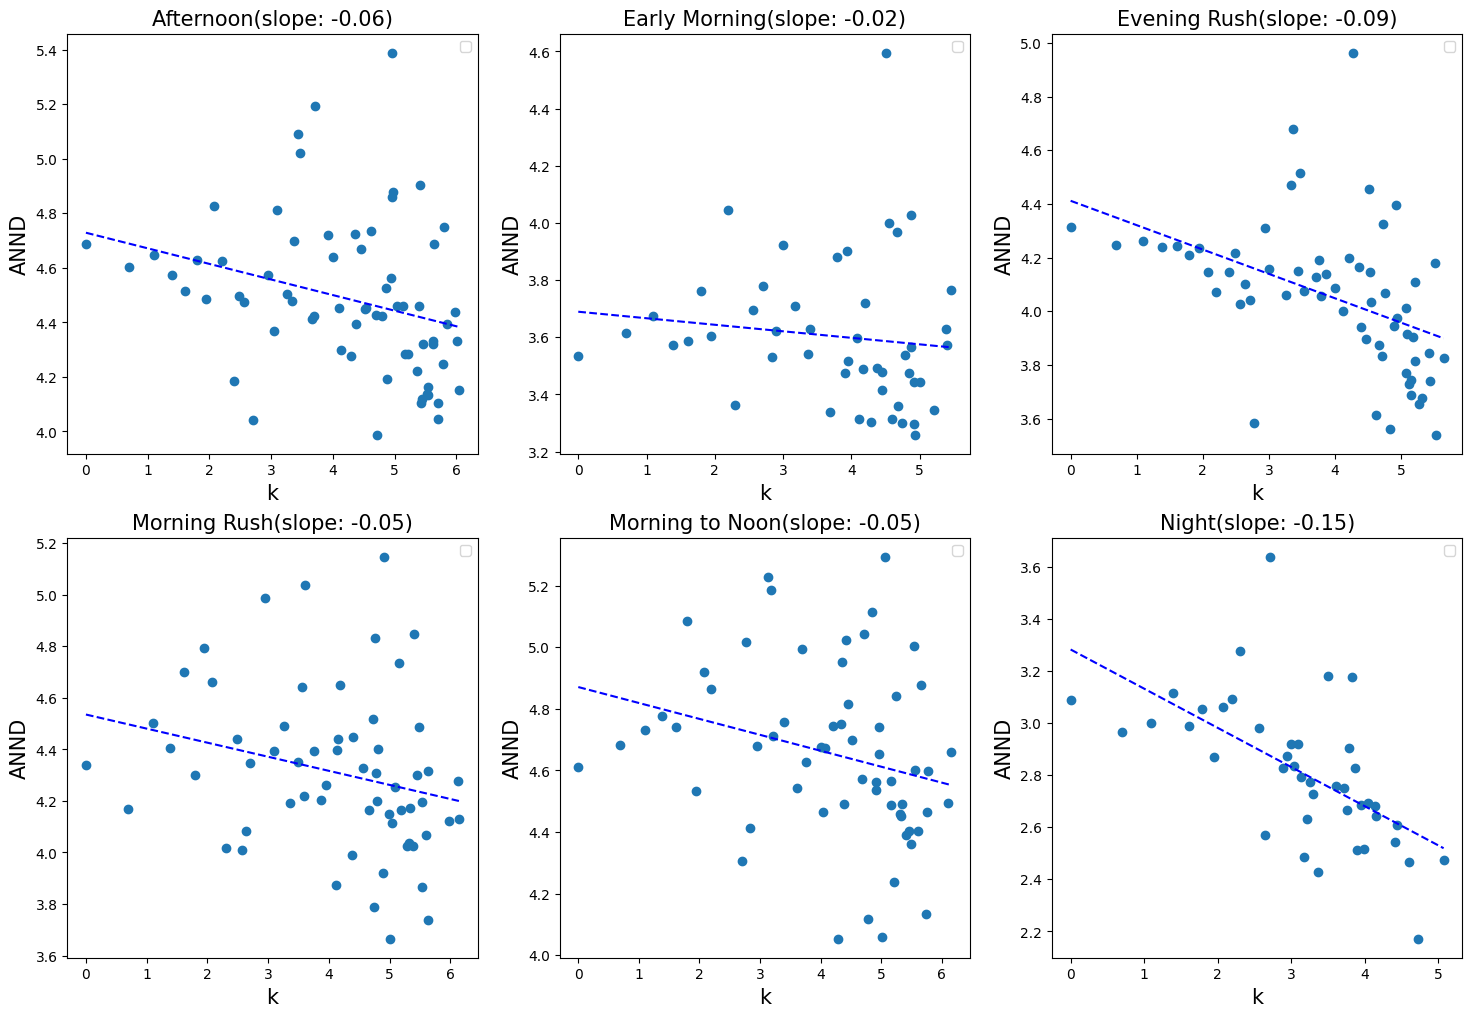

In [27]:
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, period in enumerate(periods):
    x_knn_k = np.log(ODs[period]["knn_k"].index)
    y_knn_k = np.log(ODs[period]["knn_k"])
    
    # 去除无穷大或 NaN 值
    mask_knn_k = ~np.isinf(x_knn_k) & ~np.isnan(x_knn_k) & ~np.isinf(y_knn_k) & ~np.isnan(y_knn_k)
    x_knn_k = x_knn_k[mask_knn_k]
    y_knn_k = y_knn_k[mask_knn_k]
    
    axs[i//3, i%3].scatter(x_knn_k, y_knn_k)
    
    # 拟合直线
    z_knn_k = np.polyfit(x_knn_k, y_knn_k, 1)
    p_knn_k = np.poly1d(z_knn_k)
    axs[i//3, i%3].plot(x_knn_k, p_knn_k(x_knn_k), "b--")
    
    slope = z_knn_k[0]  # 获取斜率
    
    axs[i//3, i%3].set_title((period+"(slope: "+str(round(slope, 2))+")"), fontsize=15)
    axs[i//3, i%3].set_xlabel("k", fontsize=15)
    axs[i//3, i%3].set_ylabel("ANND", fontsize=15)
    axs[i//3, i%3].legend()


In [25]:
for period in periods:
    print(f"{period}: {ODs[period]['deg_corr_coef']}")

Afternoon: -0.08456121164112625
Early Morning: -0.03657097765917089
Evening Rush: -0.12560979981466766
Morning Rush: -0.054360225058721685
Morning to Noon: -0.026470438257409735
Night: -0.11043002402111977
